In [150]:
]activate ../../../

  Activating project at `~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode`


In [154]:
using GLMakie

In [152]:
using Revise
includet("./base.jl")
using StatsBase

In [153]:
using CairoMakie

# No-space

In [98]:
N = 100
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_nospace(logKs, lis, 100000000000;
    save_sols=true,
    solver=QNDF(),
)
countmap(xx[1])

┌ Warning: At t=3.8813448794985767e6, dt was forced below floating point epsilon 4.656612873077393e-10, and step error estimate = 1.1255581043864076. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623


  2.434539 seconds (6.40 M allocations: 538.512 MiB, 11.83% gc time)


Dict{SciMLBase.ReturnCode.T, Int64} with 2 entries:
  Unstable => 1
  Success  => 9999

### Testing

In [123]:
ci = rand(CartesianIndices(xx.maxresids))

CartesianIndex(88, 31)

In [124]:
@show logKs[ci.I[1]]
@show lis[ci.I[2]]
@show xx.maxresids[ci]

logKs[ci.I[1]] = 4.333333333333333
lis[ci.I[2]] = 0.30303030303030304
xx.maxresids[ci] = 0.139894755462592


0.139894755462592

In [145]:
mmp = MMParams(;
    K=10 ^ 4.333333333,
    m=1.,
    l=0.303030303030,
    k=0.,
    c=1.,
    d=1.,
)
mmicrm_params = mmp_to_mmicrm(mmp)
p = make_mmicrm_problem(mmicrm_params, [1., 0., 0.], 10000000000)
s = solve(p, QNDF());
# p = make_mmicrm_ss_problem(mmicrm_params, copy(u0))
# s = solve(p, DynamicSS(solver); kwargs...)

In [146]:
mmicrmmaxresid(s.u[end], mmicrm_params)

0.3627696161856875

In [169]:
u = copy(s.u[end])
du = similar(u)
du .= 0.

s.prob.f(du, u, s.prob.p, 0.)

du

3-element Vector{Float64}:
  0.3627164401209818
 -0.3627696161856875
  5.317606519383844e-5

In [170]:
mmicrm_params

SAMMiCRMParams{1, 2, Float64, 2, 4}([1.0], [1.0, 1.0], [1.0], [21544.346883782924, 0.0], [1.0, 1.0], [0.30303030303 0.0], [1.0 1.0], [0.0 1.0;;; 0.0 0.0])

In [156]:
f = plot_mmicrm_sol(s)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

### Kaka

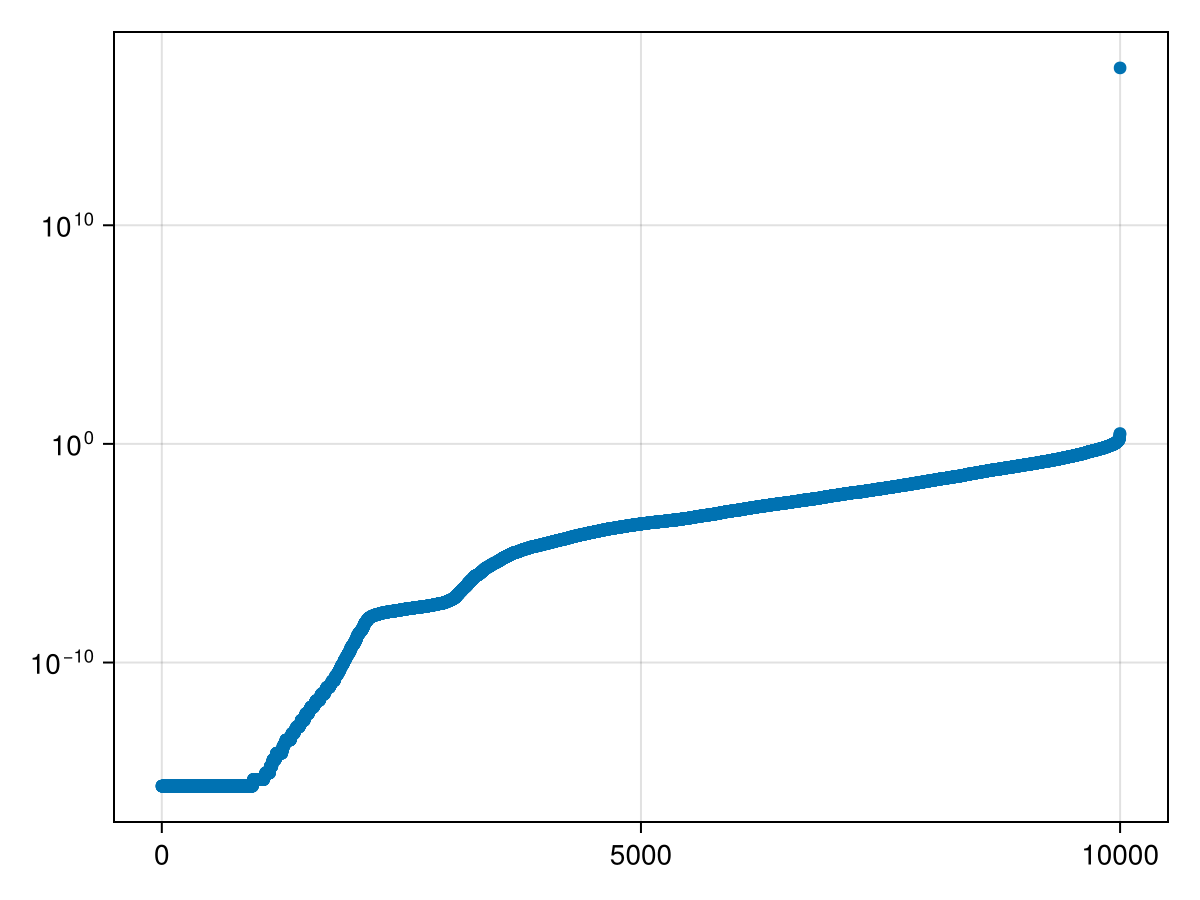

In [99]:
yy = getindex.(xx.final_states, 1)
yy = xx.maxresids
yy = clamp.(yy, max(minimum(abs, yy), eps()), Inf)
scatter(sort(yy[:]);
    axis=(;
        yscale=log10,
    )
)

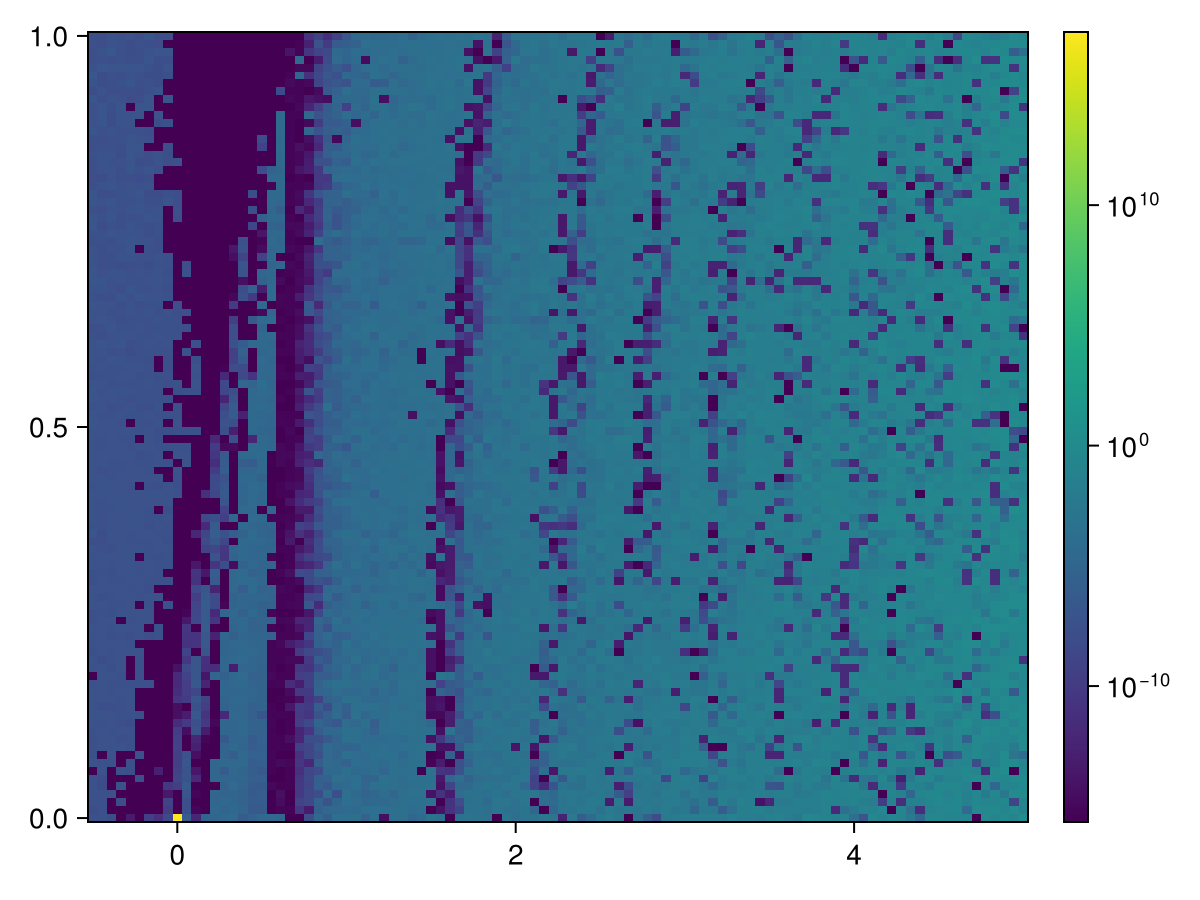

In [100]:
# yy = getindex.(xx.final_states, 3)
yy = xx.maxresids
fap = heatmap(logKs, lis, clamp.(yy, max(minimum(abs, yy), eps()), Inf);
    colorscale=log10,
# fap = heatmap(logKs, lis, yy;
    # colorrange=(1., 1.) .+ (-1., 1.) .* 0.9
)
Colorbar(fap.figure[1,2], fap.plot)
fap

# Space

In [31]:
N = 2
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_space(logKs, lis, 1000;
    solver=QNDF(),
    save_sols=true,
)
countmap(xx.retcodes)

 75.236273 seconds (2.44 M allocations: 6.562 GiB, 86.81% gc time, 0.25% compilation time)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 4

In [30]:
countmap(xx.retcodes)

Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 4

## Testing

In [189]:
N = 100
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_nospace(logKs, lis, 10000000;
    save_sols=true
)
countmap(xx[1])

  3.646430 seconds (8.92 M allocations: 703.548 MiB, 1.64% gc time)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 10000

In [243]:
s = xx.sols[50,50];
s.u[end]

3-element Vector{Float64}:
 165.31362815996357
   1.0029839480997134
   0.4934416119426851

In [296]:
L = 2
sN = 10000
epsilon = 1e-5
dx = L / (sN + 1)

mmp = MMParams(;
    m=1.,
    K=10.,
    c=1.,
    d=1.,
    l=1.,
)
sps = SASMMiCRMParams(
    mmp_to_mmicrm(mmp),
    SA[1e-12, 1., 1.], 
    make_cartesianspace_smart(1; dx),
    nthreads()
)
u0 = reduce(hcat, [[1., 0., 0.] .+ epsilon .* randn(3) for _ in 1:sN])
sp = make_smmicrm_problem(sps, u0, 10000)

@time ss = solve(sp, TRBDF2());

  4.147894 seconds (320.91 k allocations: 3.489 GiB, 1.83% gc time)


In [310]:
sum(ss.u[end]; dims=2)[:,1]

3-element Vector{Float64}:
 77174.34089890757
 13023.18731739632
  9802.471783694742

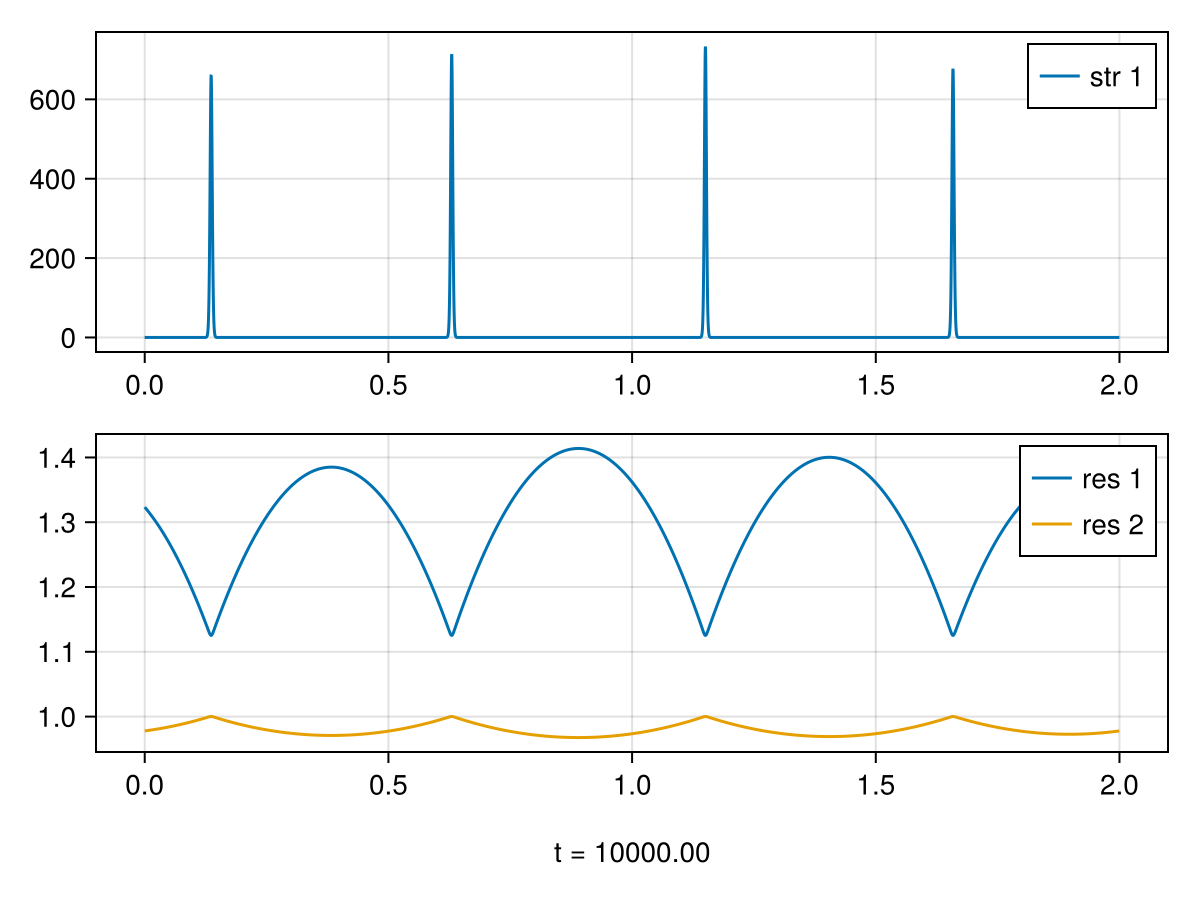

In [311]:
plot_1dsmmicrm_sol_snap(ss, -1)

# Testing

In [66]:
mmp = MMParams(;
    K=10 ^ 1.,
    m=1.,
    l=0.5,
    k=0.,
    c=1.,
    d=1.,
)
mmicrm_params = mmp_to_mmicrm(mmp)
p = make_mmicrm_problem(mmicrm_params, [1., 0., 0.], 10000000000)
s = solve(p, TRBDF2());
# p = make_mmicrm_ss_problem(mmicrm_params, copy(u0))
# s = solve(p, DynamicSS(solver); kwargs...)

In [93]:
mmicrmresid(s.u[end], s.prob.p)

3-element Vector{Float64}:
  4.540518929334589e-6
 -5.461991674948763e-6
  9.214727461070993e-7

In [69]:
check_mmicrmparams(mmicrm_params)

In [68]:
mmicrmfunc!()

mmicrmfunc! (generic function with 12 methods)

In [67]:
uninplace(mmicrmfunc!)()

#18 (generic function with 1 method)